In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# from fastai.tabular import *
from fastai.text import *

In [3]:
PATH = Path()

In [67]:
# train = pd.read_csv(PATH/"train.csv")
# test = pd.read_csv(PATH/"test.csv")

train = pd.read_csv(PATH/"train_clean.csv")   # data-without-drift
test = pd.read_csv(PATH/"test_clean.csv")

# Data Visualization

IMPORTANT: While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001

In [20]:
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [ ]:
len(train)

In [ ]:
# imbalanced dataset
c = Counter(train.open_channels); c

In [ ]:
c.most_common()

In [ ]:
for i,n in c.most_common():
    print(f"{i}: {round(n/5000000, 2)}")

In [ ]:
train.describe()

In [ ]:
# signal stats
print(f"mean: {train.signal.mean()}\nmin: {train.signal.min()}\nmax: {train.signal.max()}")

In [ ]:
# open channel stats
print(f"mean: {train.open_channels.mean()}\nmin: {train.open_channels.min()}\nmax: {train.open_channels.max()}")

In [8]:
res = 10000    # step

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train.signal[0::res])

plt.vlines(range(0,len(train),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - batches / {res}',size=20)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train.open_channels[0::res])

plt.vlines(range(0,len(train),500000),-1,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Open Channels', size=16);
plt.title(f'Open Channels - batches / {res}',size=20)
plt.show()

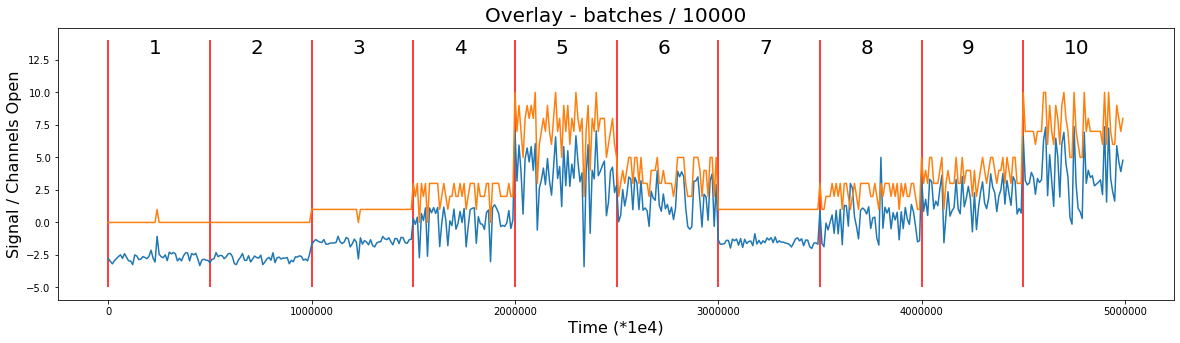

In [10]:
plt.figure(figsize=(20,5))
plt.plot(train.signal[::res])
plt.plot(train.open_channels[::res])

plt.vlines(range(0,len(train),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(10): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal / Channels Open', size=16); 
plt.title(f'Overlay - batches / {res}',size=20)
plt.show()

## zoom in

In [106]:
def show_subset(start,end,step,add_fields=[]):
    plt.figure(figsize=(20,5))
    plt.plot(train.signal[start:end:step], label='signal')
    plt.plot(train.open_channels[start:end:step], label='open_channels')
    [plt.plot(train[field][start:end:step], label=field) for field in add_fields]
    plt.xlabel('Time (*1e4)', size=16)
    plt.ylabel('Signal / Channels Open', size=16); 
    plt.title(f'{start} - {end}  ({end-start}/{step})',size=20)
    plt.legend()
    plt.show()

def random_subsets(n=10, length=500, step=10, add_fields=None):
    for k in range(n):
        start = np.random.randint(0, len(train)-length)
        end = start + length
        show_subset(start,end,step,add_fields)

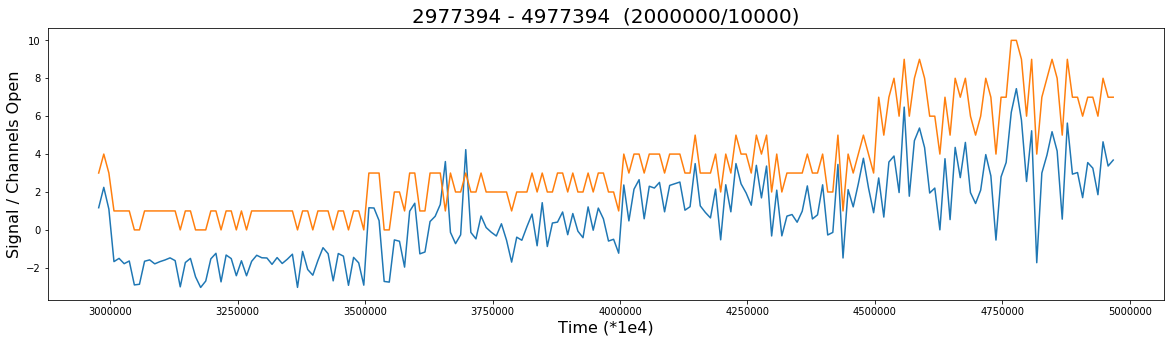

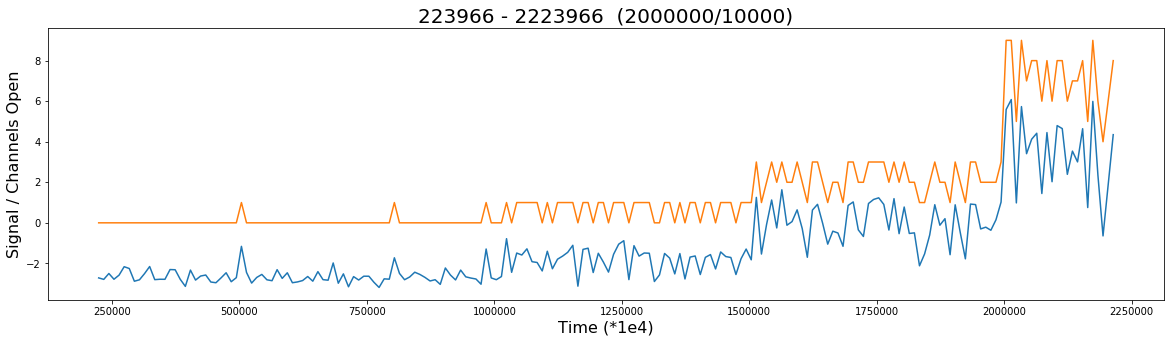

In [14]:
show_subsets(n=2, length=2000000, step=10000)

### Strange Behavior: open_channels < signal (~4000)

In [21]:
train[train.open_channels < train.signal]

,time,signal,open_channels
478587,47.8588,4.999800,0
478609,47.8610,3.537600,0
478610,47.8611,0.586400,0
599999,60.0000,0.297600,0
3642932,364.2933,4.999857,3
...,...,...,...
3822653,382.2654,4.445693,3
3822697,382.2698,4.999802,2
3822699,382.2700,2.708730,2
3822750,382.2751,3.152937,2


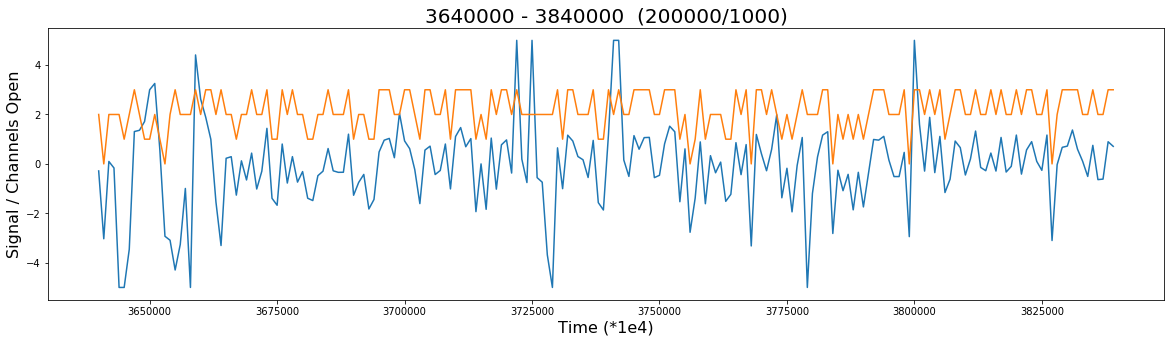

In [8]:
show_subset(3640000,3840000,1000)

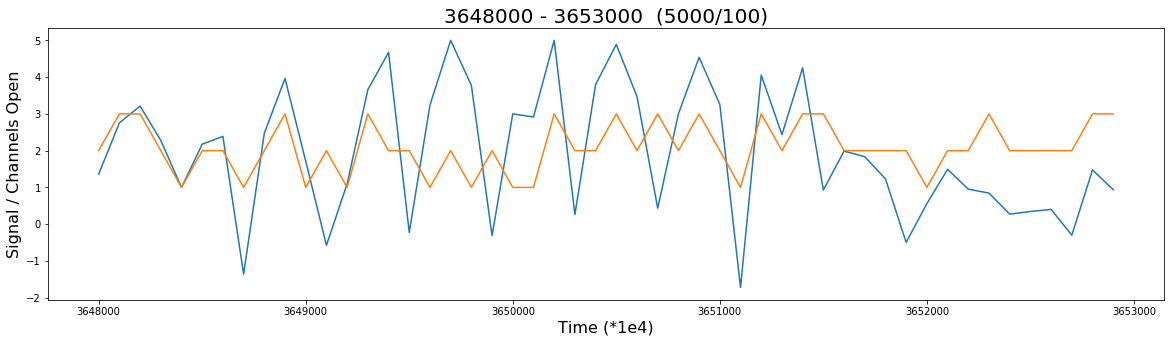

In [39]:
show_subset(3648000,3653000,100)

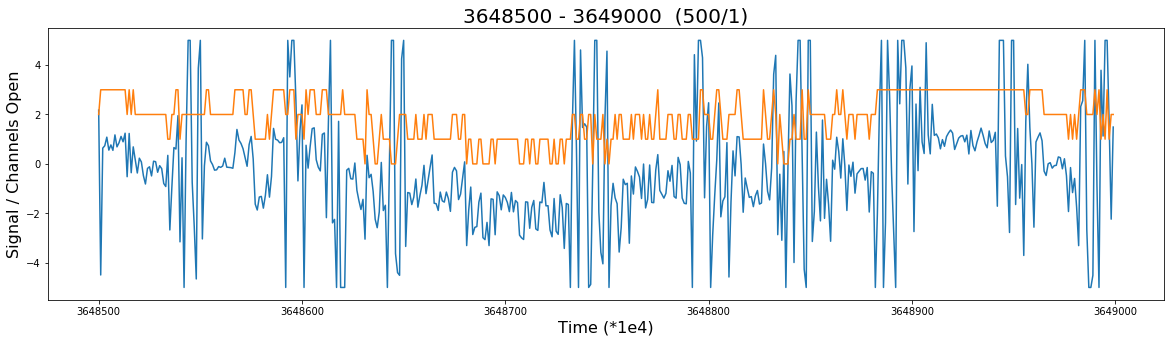

In [9]:
show_subset(3648500,3649000,1)

In [21]:
train[train.open_channels < train.signal]

,time,signal,open_channels
478587,47.8588,4.999800,0
478609,47.8610,3.537600,0
478610,47.8611,0.586400,0
599999,60.0000,0.297600,0
3642932,364.2933,4.999857,3
...,...,...,...
3822653,382.2654,4.445693,3
3822697,382.2698,4.999802,2
3822699,382.2700,2.708730,2
3822750,382.2751,3.152937,2


## Test

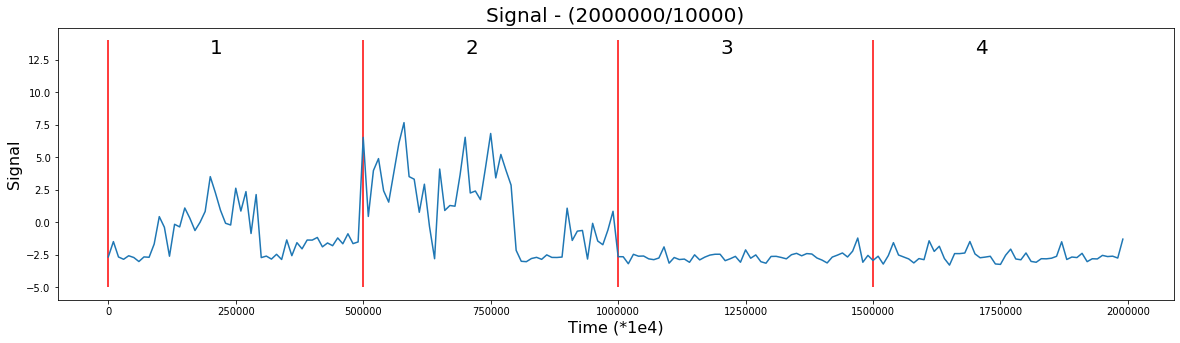

In [23]:
plt.figure(figsize=(20,5))
plt.plot(test.signal[0::res])

plt.vlines(range(0,len(test),500000),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(4): plt.text(j*500000+200000,13,str(j+1),size=20)  # show batch numbers

plt.xlabel('Time (*1e4)', size=16)
plt.ylabel('Signal', size=16); 
plt.title(f'Signal - ({len(test)}/{res})',size=20)
plt.show()

# Additional Features

In [68]:
seq_len = 4000
bs = 30

In [11]:
# normalize
train_mean = train.signal.mean()
train_sigma = train.signal.std()

train['signal'] = (train.signal - train_mean) / train_sigma
test['signal'] = (test.signal - train_mean) / train_sigma

In [75]:
train.groupby('batch')['signal'].transform('ewm')

ValueError: 'ewm' is not a valid function name for transform(name)

In [29]:
train['signal'].ewm(span=10).mean()

0         -1.142629
1         -1.163786
2         -1.098305
3         -1.163284
4         -1.202646
             ...   
4999995    1.507248
4999996    1.424340
4999997    1.489406
4999998    1.624739
4999999    1.716430
Name: signal, Length: 5000000, dtype: float64

In [120]:
# np.clip is hacky way to get the std to near 1

def grouping_(df, seq, batch=500000, section=100000):
    # group by batch
    df['batch'] = df.groupby(df.index//batch, sort=False)['signal'].agg(['ngroup']).values
    df['batch'] = df['batch'].astype(np.uint16)
    
    # group by section
    df['section'] = df.groupby(df.index//section, sort=False)['signal'].agg(['ngroup']).values
    df['section'] = df['section'].astype(np.uint16)

    # group by seq_len
    df['sequence'] = df.groupby(df.index//seq, sort=False)['signal'].agg(['ngroup']).values
    df['sequence'] = df['sequence'].astype(np.uint16)

    # group_mean and percent change from group_mean
    df['seq_mean'] = df.groupby('sequence')['signal'].transform('mean')
    df['pct_seq_mean'] = np.clip((df['signal']/df['seq_mean'])-1,-2,2) #
    
    df['sct_mean'] = df.groupby('section')['signal'].transform('mean')
    df['pct_sct_mean'] = np.clip((df['signal']/df['sct_mean'])-1,-2,2) #
    
    df['bat_mean'] = df.groupby('batch')['signal'].transform('mean')
    df['pct_bat_mean'] = np.clip((df['signal']/df['bat_mean'])-1,-2,2) #

def ewma_(df, windows):
    for window in windows:
        df['ewma_' + str(window)] = df.groupby('section')['signal'].transform(lambda x: x.ewm(span=window).mean()).values
    
def shift_with_pct_change_(df, windows):
    # markovian process -> shift by 1 should be enough... but there appears to be delay in data sometimes
    for window in windows:
        df['shift_' + str(window)] = df['signal'].shift(window).fillna(df['signal'])
        df['pct_change_' + str(window)] = np.clip((df['signal']/df['shift_' + str(window)])-1,-4,4) #
        
        # don't think positive signal shift helps...
#         df['signal_shift_next_' + str(window)] = df['signal'].shift(-1 * window).fillna(df['signal'])
#         df['pct_change_next_' + str(window)] = np.clip((df['signal']/df['signal_shift_next_' + str(window)])-1,-4,4)
    
def square_signal_(df):
    df['signal2'] = df['signal']**2

In [121]:
def feature_engineering_(df, seq_len:int, windows:list):
    grouping_(df, seq_len)
    shift_with_pct_change_(df, windows)
    ewma_(df, [10,100,1000])
    square_signal_(df)

In [122]:
for df in [train,test]:
    feature_engineering_(df, seq_len, [1,5,10,20,50])

In [79]:
# check for na values
train.isnull().sum(), test.isnull().sum()

(time             0
 signal           0
 open_channels    0
 batch            0
 section          0
 sequence         0
 seq_mean         0
 pct_seq_mean     0
 sct_mean         0
 pct_sct_mean     0
 bat_mean         0
 pct_bat_mean     0
 shift_1          0
 pct_change_1     0
 shift_5          0
 pct_change_5     0
 shift_10         0
 pct_change_10    0
 shift_20         0
 pct_change_20    0
 shift_50         0
 pct_change_50    0
 ewma_10          0
 signal2          0
 dtype: int64,
 time             0
 signal           0
 batch            0
 section          0
 sequence         0
 seq_mean         0
 pct_seq_mean     0
 sct_mean         0
 pct_sct_mean     0
 bat_mean         0
 pct_bat_mean     0
 shift_1          0
 pct_change_1     0
 shift_5          0
 pct_change_5     0
 shift_10         0
 pct_change_10    0
 shift_20         0
 pct_change_20    0
 shift_50         0
 pct_change_50    0
 ewma_10          0
 signal2          0
 dtype: int64)

In [112]:
cols = train.columns.values
dels = np.array(['time', 'sequence', 'batch', 'section', 'open_channels'], dtype='object')
feats = list(np.setdiff1d(cols,dels))
print(feats)

['bat_mean', 'ewma_10', 'ewma_100', 'ewma_1000', 'pct_bat_mean', 'pct_change_1', 'pct_change_10', 'pct_change_20', 'pct_change_5', 'pct_change_50', 'pct_sct_mean', 'pct_seq_mean', 'sct_mean', 'seq_mean', 'shift_1', 'shift_10', 'shift_20', 'shift_5', 'shift_50', 'signal', 'signal2']


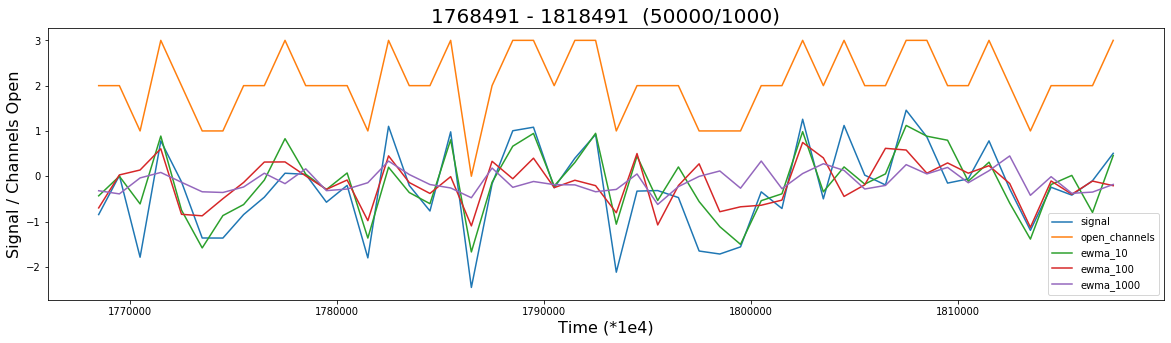

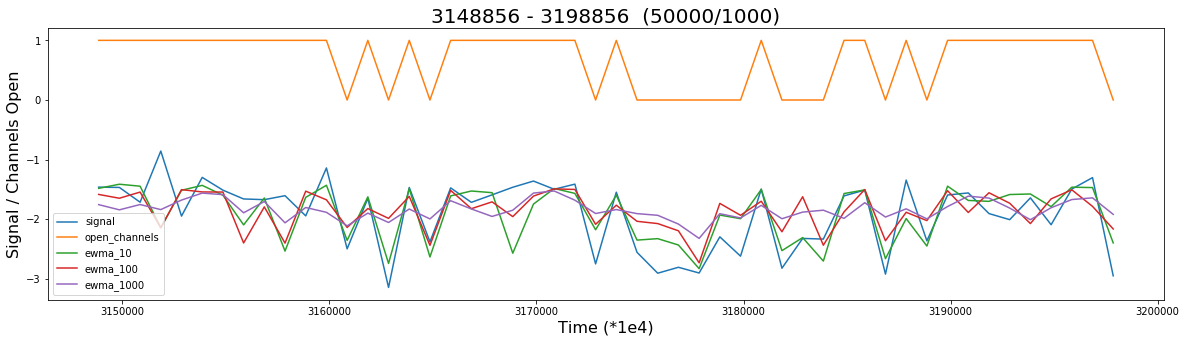

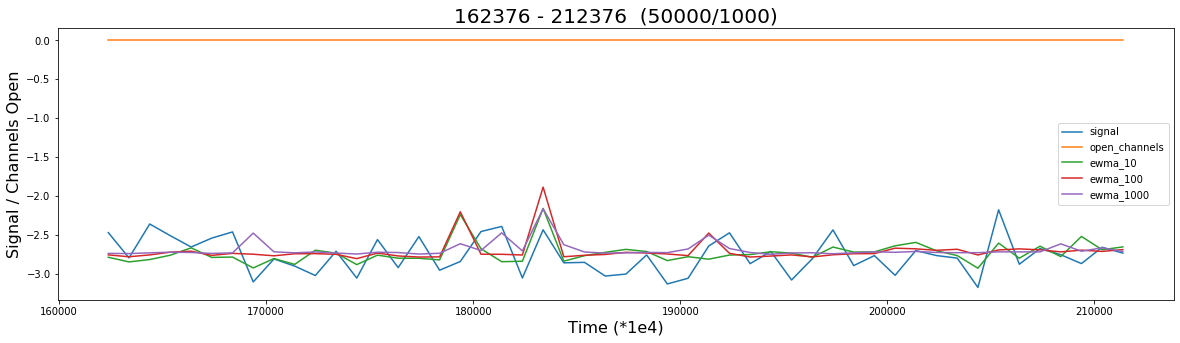

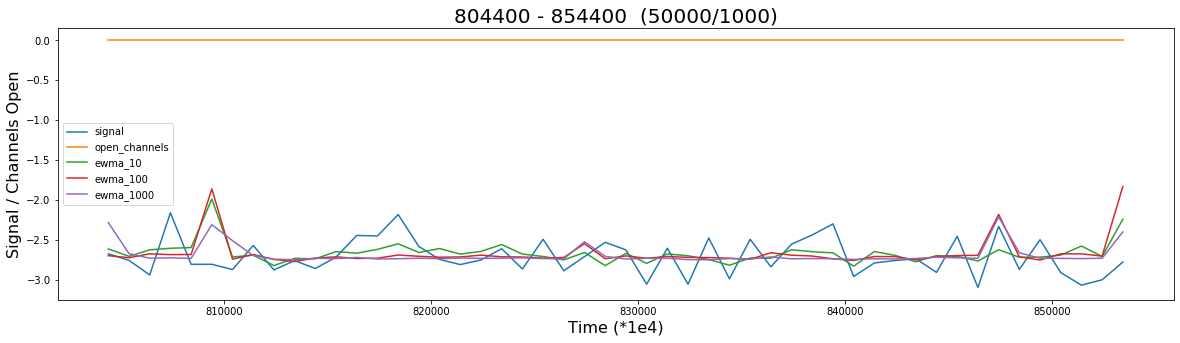

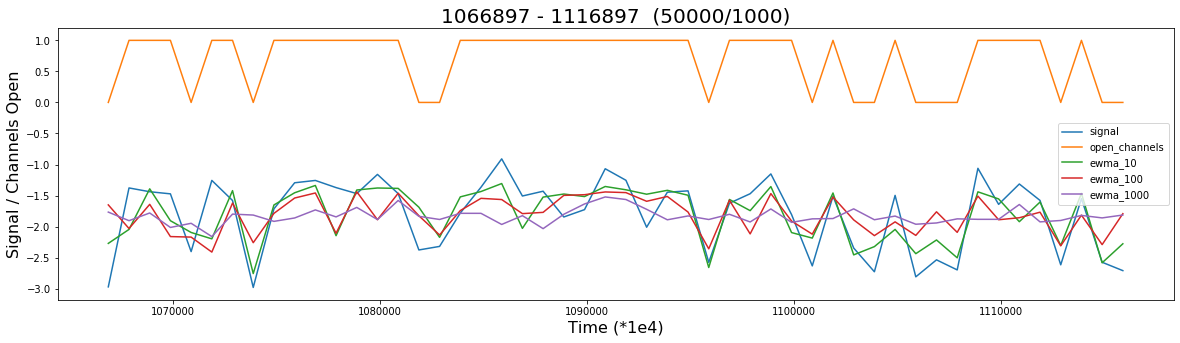

In [123]:
random_subsets(n=5, length=50000, step=1000, add_fields=['ewma_10', 'ewma_100', 'ewma_1000'])

In [57]:
# feats = ['signal', 'group_mean', 'pct_change_group_mean', 'pct_change_prev_1', 'pct_change_next_1']  

X = np.array(list(train.groupby('sequence').apply(lambda x: x[feats].values)))
Y = np.array(list(train.groupby('sequence').apply(lambda x: x['open_channels'].values)))

TEST = np.array(list(test.groupby('sequence').apply(lambda x: x[feats].values)))

In [58]:
print(X.shape, Y.shape)
print(TEST.shape)

(1250, 4000, 14) (1250, 4000)
(500, 4000, 14)


In [59]:
print(f"means: {X.mean(axis=(0,1))}")
print(f" stds: {X.std(axis=(0,1))}")

means: [ 1.754097e-13 -3.224784e-02 -9.021827e-02 -1.060664e-01 -7.950903e-02 -1.327891e-01 -1.168207e-03 -6.543339e-07
 -5.437445e-06 -1.127208e-05 -2.851407e-06 -3.048769e-05 -1.754979e-14  9.999998e-01]
 stds: [0.889433 1.026751 1.232129 1.275793 1.196796 1.337203 0.916579 1.       0.999999 0.999997 0.999999 0.999988 1.
 1.180134]


In [ ]:
# percent change can be approximated by log differences...

### split trn/val

In [58]:
trn_idx,val_idx = trn_val_split(X.shape[0])

trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]
print(trn_x.shape, val_x.shape)

(1000, 4000, 6) (250, 4000, 6)


In [ ]:
# normalize each feature individually after train/val split??

### DataBunch

In [60]:
trn_ds = Ion_Dataset(trn_x, trn_y)
val_ds = Ion_Dataset(val_x, val_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)

data = DataBunch(trn_dl, val_dl)

# WaveNet

In [40]:
#convlution formula: output = input + 2*padding - kernel_size - (kernel_size-1)*(dilation-1)

def padding(i, o, d, k=3, s=1):
    return ((o-1)*s + (k-1)*(d-1) + k - i)/2

# k=3: padding = dilation    => maintain size
# k=2: padding = dilation//2 => maintain size
# k=1: padding = 0           => maintain size

In [78]:
class Gated_Activation_Unit(Module):
    # w/ residual connection, batchnorm, and dropout
    def __init__(self, c, d, k=2, drop=0.2):        
        self.conv1 = nn.Conv1d(c, c, k, padding=pad(k,d), dilation=d) 
        self.tanh = nn.Tanh()
        self.conv2 = nn.Conv1d(c, c, k, padding=pad(k,d), dilation=d)
        self.sigm = nn.Sigmoid()
        self.conv_out = nn.Conv1d(c, c, 1)
        self.bn = nn.BatchNorm1d(c)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        res = x
        tanh = self.tanh(self.conv1(x))
        sigm = self.sigm(self.conv2(x))
        x = self.conv3(tanh * sigm)
        x = self.bn(res + x)
        return self.drop(x)
       
    def pad(k,d): return {3:d, 2:d//2, 1:0}[k]
    
    
class WaveBlock(Module):
    def __init__(self, in_c, out_c, dilations=10):
        self.conv_in = nn.Conv1d(in_c, out_c, 1)
        self.layers = nn.Sequential([Gated_Activation_Unit(out_c,2**i) for i in range(dilations)])
    
    def forward(self, x): return self.layers(self.conv_in(x))
    
    
class CBR(Module):
    def __init__(self, in_c, out_c, k=3):
        self.layers = nn.Sequential(
            nn.Conv1d(in_c, out_c, k, padding=k//2),
            nn.BatchNorm1d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x): return self.layers(x)

In [79]:
class WaveNet(Module):
    # without the skip connections
    def __init__(self, in_dim=1, out_dim=11, channels=[16,32,64,128], dilations=[12,8,4,1], drop=0.2):
        channels = [in_dim]+channels
        
        self.blocks = nn.Sequential(WaveBlock(*args,drop) for *args in zip(channels[0::1], channels[1::1], dilations))
        # zip channels/dilations yielding: (c0,c1,d0), (c1,c2,d1), (c2,c3,d2), etc.
        self.out = nn.Linear(channels[-1], out_dim)
        self.drop = nn.Dropout(drop)
#         self.cbr1 = CBR(in_dim,64)
#         self.cbr2 = CBR(128,32)

    def forward(self, x):
        x = x.permute(0,2,1)
        #x = self.cbr1(x)
        x = self.blocks(x)
        #x = self.cbr2(x)
        x = self.drop(x)
        
        x = x.permute(0,2,1)
        return self.out(x)

In [80]:
model = WaveNet(6,11)

# Deep-Channel data

In [ ]:
train.head()

In [ ]:
dataset = train.values.astype('float64')
idataset = dataset[:, 2].astype(int)

In [ ]:
timep = dataset[:, 0]
timep

In [ ]:
maxer = np.amax(dataset[:, 2])
maxchannels = maxer.astype('int')
maxchannels

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale dataset between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset.min(), dataset.max(), dataset.mean(), dataset.std()

In [ ]:
batch_size = 256

train_size = int(len(dataset) * 0.80)
modder = math.floor(train_size/batch_size)
train_size = int(modder*batch_size)
test_size = int(len(dataset) - train_size)
modder = math.floor(test_size/batch_size)
test_size = int(modder*batch_size)

print(f'training set = {train_size}')
print(f'test set = {test_size}')
print(f'total length = {test_size + train_size}')

In [ ]:
x_train = dataset[:, 1]
y_train = idataset[:]
x_train = x_train.reshape((len(x_train), 1))    #(5000000, 1)
y_train = y_train.reshape((len(y_train), 1))    #(5000000, 1)

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE - Synthetic Minority Over-sampling Technique -> resample all classes to equal the majority class
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_res, Y_res = sm.fit_sample(x_train, y_train)

In [ ]:
Counter(y_train[:,0]).most_common()

In [ ]:
Counter(Y_res).most_common()

In [ ]:
def to_categorical(y, num_classes):
    """ 1-hot encode a tensor => for use w/ categorical cross-entropy """
    return np.eye(num_classes, dtype='uint8')[y]

In [ ]:
from sklearn.utils import shuffle

In [ ]:
yy_res = Y_res.reshape((len(Y_res), 1))
yy_res = to_categorical(yy_res, num_classes=maxchannels+1)
xx_res, yy_res = shuffle(X_res, yy_res)  # x: (13641672, 1), y: (13641672, 1, 11)

In [ ]:
trainy_size = int(len(xx_res) * 0.80)
modder = math.floor(trainy_size/batch_size)
trainy_size = int(modder*batch_size)
testy_size = int(len(xx_res) - trainy_size)
modder = math.floor(testy_size/batch_size)
testy_size = int(modder*batch_size)

print('training set = ', trainy_size)
print('test set =', testy_size)
print('total length =', testy_size+trainy_size)

In [ ]:
in_train, in_test = xx_res[0:trainy_size,0], xx_res[trainy_size:trainy_size+testy_size, 0]
target_train, target_test = yy_res[0:trainy_size,:], yy_res[trainy_size:trainy_size+testy_size, :]

in_train = in_train.reshape(len(in_train), 1, 1, 1)
in_test = in_test.reshape(len(in_test), 1, 1, 1)

In [ ]:
in_train.shape, in_test.shape

In [ ]:
target_train.shape, target_test.shape

In [ ]:
# model
newmodel = Sequential()
timestep = 1
input_dim = 1
newmodel.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
                             input_shape=(None, timestep, input_dim)))
newmodel.add(TimeDistributed(MaxPooling1D(pool_size=1)))
newmodel.add(TimeDistributed(Flatten()))

newmodel.add(LSTM(256, activation='relu', return_sequences=True))
newmodel.add(BatchNormalization())
newmodel.add(Dropout(0.2))

newmodel.add(LSTM(256, activation='relu', return_sequences=True))
newmodel.add(BatchNormalization())
newmodel.add(Dropout(0.2))

newmodel.add(LSTM(256, activation='relu'))
newmodel.add(BatchNormalization())
newmodel.add(Dropout(0.2))

newmodel.add(Dense(maxchannels+1))
newmodel.add(Activation('softmax'))

newmodel.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001, momentum=0.9, nesterov=False),
                 metrics=['accuracy', Precision(), Recall(), F1Score(num_classes=maxchannels+1, average='micro')])

# Simple 2-layer RNN from signal

In [ ]:
seq_len = 4000
bs = 30

In [ ]:
X = train['signal'].values.reshape(-1, seq_len, 1)
y = train['open_channels'].values.reshape(-1, seq_len)

X.shape, y.shape

In [55]:
def trn_val_split(rows, percent=0.2):
    "returns trn_idxs, val_idxs"
    indices = np.random.permutation(rows)  # randomly permute rows
    num = int(rows*percent)
    return indices[num:], indices[:num]

In [ ]:
trn_idx,val_idx = trn_val_split(X.shape[0])

trn_x, val_x = X[trn_idx], X[val_idx]
trn_y, val_y = Y[trn_idx], Y[val_idx]
print(trn_x.shape, val_x.shape)

### normalize training and validation

In [ ]:
trn_mean = trn_x.mean()
trn_sigma = trn_x.std()

trn_x = (trn_x - trn_mean)/trn_sigma
val_x = (val_x - trn_mean)/trn_sigma

print(trn_x.mean(), trn_x.std())
print(val_x.mean(), val_x.std())

### DataBunch

In [61]:
class Ion_Dataset(Dataset):
    def __init__(self, X, Y=None):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float)
        y = torch.tensor(self.Y[idx], dtype=torch.long) if self.Y else None
        return (x,y) if y else x

In [ ]:
trn_ds = Ion_Dataset(trn_x, trn_y)
val_ds = Ion_Dataset(val_x, val_y)

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False)

db = DataBunch(trn_dl, val_dl)

### Model & Learner

In [87]:
class Bi_RNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, output_dim=11, num_layers=2):
        super(Bi_RNN, self).__init__()

        self.linear_in = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.linear_out = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input):
        linear_input = self.linear_in(input)
        lstm_out, self.hidden = self.lstm(linear_input)
        return self.linear_out(lstm_out)

model = Bi_RNN()
loss = CrossEntropyFlat()

from sklearn.metrics import f1_score

def f1(preds, targs):
    return tensor(f1_score(targs.view(-1).detach().cpu(), preds.argmax(-1).view(-1).detach().cpu(), average='macro'))

learn = Learner(db, model, loss_func=loss, metrics=[f1])

In [ ]:
# learn.clip_grad()

### Fit

In [ ]:
learn.fit(5, lr=1e-2)

# Seq Databunch

In [ ]:
class SeqProcessor():
    def __init__(self, ds:Collection=None, seq_len=5000):  self.seq_len = seq_len
    def process(self, ds:Collection):  ds.items = ds.items.reshape(-1, seq_len, 1)

In [ ]:
class SeqBatchSampler(torch.utils.data.Sampler):
    "split data up into n batches of seq_len"
    def __init__(self,data_source,seq_len):
        assert len(data_source)%seq_len==0
        self.seq_len = seq_len
        self.data_source = data_source.reshape(-1, seq_len, 1)

    def __len__(self): return len(self.data_source)
    def __iter__(self): return iter(self.data_source)

In [ ]:
d = ItemList.from_df(train, PATH, cols=1, processor=SeqProcessor)

In [ ]:
d.items

In [ ]:
def custom_collate(data):
    x,y = [],[]
    for ll in data:
        x.append(ll.x.items)
        y.append(ll.y.items)
    return (torch.Tensor(x), torch.LongTensor(y))

In [ ]:
class SeqDataBunch(DataBunch):
    @classmethod      # cls => databunch Class
    def create(cls, train_ds, valid_ds, test_ds=None, path='.',bs:int=30, seq_len:int=5000, **kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        dataloaders = []
        for ds in datasets:
            samp = SeqBatchSampler(ds,seq_len=seq_len)
            dataloaders.append(DataLoader(ds, batch_size=bs, sampler=samp))
        return cls(*dataloaders, path=path, collate_fn=custom_collate)
    
    def normalize(self, mean=0., std=1.)->None:
        self.add_tfm(partial(self.norm_x, mean=mean, std=std))
        return self
    
    @staticmethod
    def norm_x(batch:Tuple[Tensor,Tensor], mean:float, std:float)->Tuple[Tensor,Tensor]:
        x,y = batch
        x = (x-mean)/std
        return x,y

In [ ]:
class SeqList(ItemList): 
    _processor = [SeqProcessor]
    #_bunch = SeqDataBunch

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)

In [ ]:
1000*.2

In [ ]:
np.arange(len(train)).reshape(-1,5000)

In [ ]:
np.random.randint(1000, size=200)

In [ ]:
idxs = np.arange(len(train)).reshape(-1,5000)[:,-int(0.2):].flatten()

In [ ]:
def valid_idxs(df,seq_len=5000,percent=0.2):
    full = np.arange(len(df)).reshape(-1,seq_len)
    rows = full.shape[0]
    num = int(rows*percent)
    idx = np.random.randint(rows, size=num)
    return full[idx].flatten()

In [ ]:
v_idxs = valid_idxs(train)

In [ ]:
v_idxs

In [ ]:
bs=100
bptt=100

v_idxs = valid_idxs(train, seq_len)

In [ ]:
data = (SeqList.from_df(train, PATH, cols=1)
        .split_by_idx(v_idxs)
        .label_from_df(cols=2, label_cls=SeqList)
        .databunch(bs=30)
       )

In [ ]:
d = data.databunch(bs=30)

In [ ]:
%debug

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

# Mixed Sequential DataBunch

In [ ]:
# class NormProcessor(PreProcessor):
#     def __init__(self, ds:Collection=None):
#         self.means = ds.items.mean()
#         self.stds = ds.items.std()

#     def process_one(self, item:Any): return self.norm(item)
#     def process(self, ds:Collection): ds.items = self.norm(ds.items)
    
#     def norm(self, x): return (x - self.means)/(self.stds + 1e-7)

In [ ]:
class SeqBatchSampler(torch.utils.data.Sampler):
    "Return batches of indexes ~> [bs,bptt]"
    def __init__(self,data_source,bs=10,bptt=5000):
        self.length = len(data_source)
        assert self.length%bs==0
        self.bs,self.bptt = bs,bptt
        self.idxs = np.arange(self.length).reshape((bs,-1))

    def __len__(self): return self.length//self.bs
    
    def __iter__(self):
        self.cur_idx = 0
        return self
        
    def __next__(self):
        cur = self.cur_idx
        end = cur+self.bptt
        self.cur_idx = end
        res = self.idxs[:,cur:end]
        if res.shape[1] == 0: raise StopIteration
        return res

In [ ]:
def custom_collate(data):
    x,y = [],[]
    for ll in data:
        x.append(ll.x.items)
        y.append(ll.y.items)
    return (torch.Tensor(x), torch.LongTensor(y))

In [ ]:
class SeqDataBunch(DataBunch):
    @classmethod      # cls => databunch Class
    def create(cls, train_ds, valid_ds, test_ds=None, path='.', bs:int=10, bptt:int=5000, **kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        dataloaders = []
        for ds in datasets:
            samp = SeqBatchSampler(ds,bs=bs,bptt=bptt)
            dataloaders.append(DataLoader(ds, batch_sampler=samp))
        return cls(*dataloaders, path=path, collate_fn=custom_collate)
    
    def normalize(self, mean=0., std=1.)->None:
        self.add_tfm(partial(self.norm_x, mean=mean, std=std))
        return self
    
    @staticmethod
    def norm_x(batch:Tuple[Tensor,Tensor], mean:float, std:float)->Tuple[Tensor,Tensor]:
        x,y = batch
        x = (x-mean)/std
        return x,y

In [ ]:
class SeqList(ItemList): 
    #_processor = [NormProcessor]
    _bunch = SeqDataBunch

    def analyze_pred(self, pred:Tensor):
        return torch.argmax(pred, dim=-1)

In [ ]:
def valid_idxs(df,bs=10,percent=0.2):
    length = len(df)
    pct = length/bs*percent
    assert pct.is_integer()
    return np.arange(length).reshape(bs,-1)[:,-int(pct):].flatten()

In [ ]:
bs=100
bptt=100

v_idxs = valid_idxs(train, bs=bs)

In [ ]:
data = (SeqList.from_df(train, PATH, cols=1)
        .split_by_idx(v_idxs)
        .label_from_df(cols=2)
        .databunch(bs=bs, bptt=bptt)
       )

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

## Visualize (unnormalized) training batch

In [ ]:
x,y = next(iter(data.train_dl))

In [ ]:
step = 100
seq = bptt//step

plt.figure(figsize=(20,5))
plt.plot(x.numpy().flatten()[::step])
plt.plot(y.numpy().flatten()[::step])

plt.vlines(range(0,bs*seq,seq),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(bs): plt.text(j*seq+(seq/2),13,str(j+1),size=20)  # show batch numbers

plt.show()

## Visualize (normalized) training batch

In [ ]:
data = data.normalize(mean=1.5597, std=3.4347)

In [ ]:
x,y = next(iter(data.train_dl))

In [ ]:
step = 100
seq = bptt//step

plt.figure(figsize=(20,5))
plt.plot(x.numpy().flatten()[::step])
plt.plot(y.numpy().flatten()[::step])

plt.vlines(range(0,bs*seq,seq),-5,14,'r')  # delineate batches (vertically from -5 to 12.5)
for j in range(bs): plt.text(j*seq+(seq/2),13,str(j+1),size=20)  # show batch numbers

plt.show()

# CNN + AWD_LSTM

In [ ]:
class ConvToLSTM(Module):
    def __init__(self, in_sz):
        self.conv = nn.Conv1d(1,in_sz,3,padding=1)
        
    def forward(self, input:Tensor):
        return self.conv(input.unsqueeze(1)).permute(0,2,1)

class mod_AWD_LSTM(Module):
    def __init__(self, in_sz:int, hid_sz:int, n_layers:int, hidden_p:float=0.2,
                 input_p:float=0.6, weight_p:float=0.5, bidir:bool=False):
        self.bs,self.in_sz,self.hid_sz,self.n_layers = 1,in_sz,hid_sz,n_layers
        self.n_dir = 2 if bidir else 1

        self.rnns = [nn.LSTM(self.in_sz if l == 0 else self.hid_sz, self.hid_sz//self.n_dir, 1,
                             batch_first=True, bidirectional=bidir) for l in range(n_layers)]
        self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
        self.rnns = nn.ModuleList(self.rnns)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

    def forward(self, input:Tensor)->Tuple[Tensor,Tensor]:
        bs,sl,emb = input.size()
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(input)
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            raw_output, new_h = rnn(raw_output, self.hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.n_layers-1: raw_output = hid_dp(raw_output)
            outputs.append(raw_output)
        self.hidden = to_detach(new_hidden, cpu=False)
        return raw_outputs, outputs

    def _one_hidden(self, l:int)->Tensor:
        "Return one hidden state."
        nh = self.hid_sz // self.n_dir
        return one_param(self).new(self.n_dir, self.bs, nh).zero_()

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range(self.n_layers)]

def get_model(in_sz=32, hid_sz=64, out_sz=11, n_layers=3, out_p=0.4, **kwargs):
    return SequentialRNN(
        ConvToLSTM(in_sz),
        mod_AWD_LSTM(in_sz,hid_sz,n_layers,**kwargs),
        LinearDecoder(out_sz, hid_sz, output_p=out_p)
    )

In [ ]:
model = get_model()

In [ ]:
from sklearn.metrics import f1_score

def f1(preds, targs):
    return tensor(f1_score(targs.view(-1).detach().cpu(), preds.argmax(-1).view(-1).detach().cpu(), average='macro'))

In [ ]:
learn = LanguageLearner(data, model, metrics=[f1])

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# learn.model.reset()

In [ ]:
learn.fit_one_cycle(1, 1e-1)

# Tabular Model

In [ ]:
from fastai.tabular import *

In [ ]:
tab_data = TabularDataBunch.from_df(PATH, train[['signal','open_channels']], 'open_channels',
                                    valid_idx=range(4000000, 5000000))#, procs=[Normalize])

In [ ]:
learn = tabular_learner(tab_data, layers=[32,64], metrics=[accuracy, f1])

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.save('tab_model')

# F1 evaluation

*positive class*: minority class(es)  
*negative class*: majority class

- Precision: number of true positive class predictions.  (minority class accuracy)
- Recall: number of positive class predictions made out of all positive examples in the dataset. (minority class coverage)
- F-Measure provides a single score that balances both the concerns of precision and recall in one number.

*precision* - TruePositives / (TruePositives + FalsePositives)  
*recall* - TruePositives / (TruePositives + FalseNegatives)

| *Binary*        | Positive Prediction | Negative Prediction |
| :-------------: | ------------------- | ------------------- |
|**Positive Class** | True Positive (TP) | False Negative (FN) |
|**Negative Class** | False Positive (FP) | True Negative (TN) |

In [ ]:
TP = (preds * y).sum(); TP

In [ ]:
prec = TP / preds.sum(); prec

In [ ]:
rec = TP / y.sum(); rec

In [ ]:
f1 = (prec*rec)/(prec+rec+1e-9)*2; f1

In [ ]:
TP = (y_pred*y_true).sum()
prec = TP/(y_pred.sum(dim=1)+eps)
rec = TP/(y_true.sum(dim=1)+eps)
res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)

In [ ]:
def evaluate(model,x,y):
    model.eval()
    with torch.no_grad():
        res = model(x)
        preds = res.argmax(dim=-1)
        f1
learn.model()